# Final Python Notebook 2: Classification Modelling & Hyperparameter Tuning

In [324]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score

In [325]:
# Load Preprocessed Dataset
df = pd.read_csv("Cleaned Cancer Dataset.csv")

In [326]:
# Fill Any Remaining Missing Value
df = df.fillna(df.mean(numeric_only=True))

In [327]:
# Declare Features and Target
X = df.drop(columns=['Mortality_Status', 'Survival_Months'])
y = df['Mortality_Status']

In [328]:
print(X.columns.tolist())

['Age', 'Sex', 'T_Stage', 'N_Stage', '6th_Stage', 'Differentiated', 'Grade', 'Tumor_Size', 'Estrogen_Status', 'Progesterone_Status', 'Regional_Node_Examined', 'Reginol_Node_Positive']


In [329]:
print(X.shape, y.shape)

(4024, 12) (4024,)


In [330]:
# Encode object columns
le = LabelEncoder()
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = le.fit_transform(X[col].astype(str))

In [331]:
# Split the Dataset (Stratified)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [332]:
print("Train class ratio:", y_train.value_counts(normalize=True))
print("Test class ratio:", y_test.value_counts(normalize=True))

Train class ratio: Mortality_Status
0    0.845915
1    0.154085
Name: proportion, dtype: float64
Test class ratio: Mortality_Status
0    0.850932
1    0.149068
Name: proportion, dtype: float64


In [333]:
# Train Models: Logistic, Decision Tree, MLP
logreg = LogisticRegression(max_iter=1000, random_state=42)
dt = DecisionTreeClassifier(random_state=42)
mlp = MLPClassifier(max_iter=1000, random_state=42)

logreg.fit(X_train, y_train)
dt.fit(X_train, y_train)
mlp.fit(X_train, y_train)

MLPClassifier(max_iter=1000, random_state=42)


=== Logistic Regression ===

Logistic Regression - Confusion Matrix:
 [[674  11]
 [101  19]] 

Logistic Regression - Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.98      0.92       685
           1       0.63      0.16      0.25       120

    accuracy                           0.86       805
   macro avg       0.75      0.57      0.59       805
weighted avg       0.83      0.86      0.82       805

Logistic Regression - AUC-ROC Score: 0.7554987834549879 


=== Decision Tree ===

Decision Tree - Confusion Matrix:
 [[586  99]
 [ 78  42]] 

Decision Tree - Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.86      0.87       685
           1       0.30      0.35      0.32       120

    accuracy                           0.78       805
   macro avg       0.59      0.60      0.60       805
weighted avg       0.80      0.78      0.79       805

Decision Tree - AUC-RO

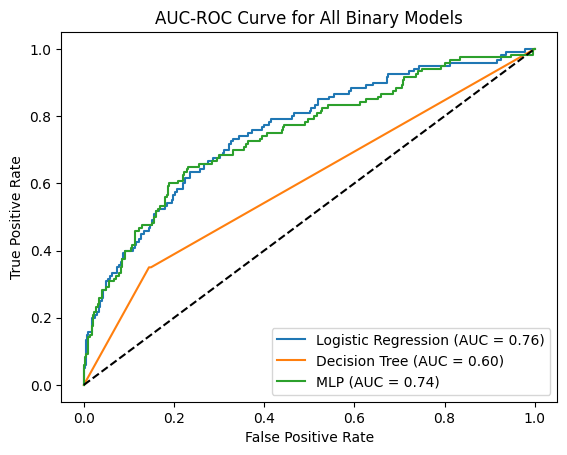

In [334]:
# Evaluate Models
models = {'Logistic Regression': logreg, 'Decision Tree': dt, 'MLP': mlp}

for name, model in models.items():
    y_pred = model.predict(X_test)

    print("\n===", name, "===\n")
    print(name, "-", "Confusion Matrix:\n", confusion_matrix(y_test, y_pred), "\n")
    print(name, "-", "Classification Report:\n", classification_report(y_test, y_pred))

    if hasattr(model, "predict_proba"):
        try:
            y_prob = model.predict_proba(X_test)[:, 1]
            auc = roc_auc_score(y_test, y_prob)
            print(name, "-", "AUC-ROC Score:", auc, "\n")
            fpr, tpr, _ = roc_curve(y_test, y_prob)
            plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")
        except:
            print(name, "-", "AUC-ROC cannot be computed for multi-class output.\n")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC-ROC Curve for All Binary Models")
plt.legend()
plt.show()

In [335]:
# Define parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear']
}

# Perform GridSearchCV
grid_search = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Best parameters
print("\nBest Hyperparameters for Logistic Regression:", grid_search.best_params_)

# Predict with tuned model
tuned_lr = grid_search.best_estimator_
y_pred_tuned = tuned_lr.predict(X_test)

# Evaluation
print("\nConfusion Matrix After Tuning:\n", confusion_matrix(y_test, y_pred_tuned))
print("\nClassification Report After Tuning:\n", classification_report(y_test, y_pred_tuned))


Best Hyperparameters for Logistic Regression: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}

Confusion Matrix After Tuning:
 [[675  10]
 [101  19]]

Classification Report After Tuning:
               precision    recall  f1-score   support

           0       0.87      0.99      0.92       685
           1       0.66      0.16      0.26       120

    accuracy                           0.86       805
   macro avg       0.76      0.57      0.59       805
weighted avg       0.84      0.86      0.82       805



In [336]:
# Summary Output
for name, model in models.items():
    acc = accuracy_score(y_test, model.predict(X_test))
    print(f"{name} Accuracy: {acc:.4f}")

print("Tuned Decision Tree Accuracy:", accuracy_score(y_test, y_pred_tuned))

Logistic Regression Accuracy: 0.8609
Decision Tree Accuracy: 0.7801
MLP Accuracy: 0.8596
Tuned Decision Tree Accuracy: 0.8621118012422361
